In [1]:
from typing import Annotated,TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage,AIMessage,BaseMessage
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.types import interrupt,Command
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(model = 'gpt-4.1-mini')


In [4]:
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage],add_messages]

In [6]:
def chat_node(state:ChatState):
    decision = interrupt({
        "type":"approval",
        "reason":"Model is about to answer a user question",
        "question":state["messages"][-1].content,
        "instruction":"Approve this question? Yes/NO"
    })
    if decision["approved"] == "NO":
        return {"messages": [AIMessage(content = "Not aprroved")]}
    else:
        response = llm.invoke(state['messages'])
        return {"messages":[response]}

In [7]:
builder = StateGraph(ChatState)
builder.add_node("chat_node",chat_node)
builder.add_edge(START,"chat_node")
builder.add_edge("chat_node",END)

checkpointer = MemorySaver()

app = builder.compile(checkpointer=checkpointer)

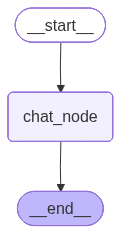

In [8]:
app

In [10]:
# Create a new thread id for this conversation
config = {"configurable": {"thread_id": '1234'}}

# ---- STEP 1: user asks a question ----
initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms.")
    ]
}

# Invoke the graph for the first time
result = app.invoke(initial_input, config=config)


In [11]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='32b09880-2c4b-445e-90d8-b234915530e8')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question', 'question': 'Explain gradient descent in very simple terms.', 'instruction': 'Approve this question? Yes/NO'}, id='fb6b8d7379d07371a4978fc843424419')]}

In [12]:
message = result['__interrupt__'][0].value
message


{'type': 'approval',
 'reason': 'Model is about to answer a user question',
 'question': 'Explain gradient descent in very simple terms.',
 'instruction': 'Approve this question? Yes/NO'}

In [13]:
user_input = input(f"\nBackend message - {message} \n Approve this question? (y/n): ")

In [14]:
# Resume the graph with the approval decision
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config,
)



In [15]:
print(final_result["messages"][-1].content)

Sure! Imagine you're standing on a hill and it's very foggy, so you can't see far around you. You want to get down to the lowest point of the hill (the valley). Since you can't see far, you decide to feel the slope of the ground right where you're standing and take a small step downhill.

Gradient descent is just like that, but for solving math problems. It's a way computers find the lowest point of a function by taking small steps in the direction that goes downhill the most until they reach the bottom. This helps in things like training machine learning models to make better predictions!
